In [2]:
# README 7.2.2 에 참조해놓은 알고리즘으로 input(low_dose_CT), label(routine_dose_CT), genrated_imgs에 적용해본 결과입니다. 
# 정확한 알고리즘을 이해하지는 못했지만, 이 알고리즘으로 얼추 Sharpness-map이 생성되는 것 같고
# generated_img sharpness-map 과 label_img Sharpness_map 의 값으로 mean-square-error
# loss를 generator loss에 추가하여 routine-dose CT image 에서 생성된 Sharpness-map 과 흡사한 결과를 생성할 수 있도록 학습.

# 막힌 부분은 아래와 같은 함수는 array 데이터 타입으로 입력을 받아야 하는데 generated, label image는 tensor 데이터 타입이여서 
# array 로 변환하여 가져오는 부분에서 현재 진행이 막혀 있습니다. 

In [17]:
import numpy as np
import cv2
import math
from PIL import Image
import matplotlib.pyplot as plt

def im2double(im):
	min_val = np.min(im.ravel())
	max_val = np.max(im.ravel())
	out = (im.astype('float') - min_val) / (max_val - min_val)
	return out



def s(x):
	temp = x>0
	return temp.astype(float)


def lbpCode(im_gray, threshold):
	width, height = im_gray.shape
	interpOff = math.sqrt(2)/2
	I = im2double(im_gray)
	pt = cv2.copyMakeBorder(I,1,1,1,1,cv2.BORDER_REPLICATE)
	right = pt[1:-1, 2:]
	left = pt[1:-1, :-2]
	above = pt[:-2, 1:-1]
	below = pt[2:, 1:-1];
	aboveRight = pt[:-2, 2:]
	aboveLeft = pt[:-2, :-2]
	belowRight = pt[2:, 2:]
	belowLeft = pt[2:, :-2]
	interp0 = right
	interp1 = (1-interpOff)*((1-interpOff) * I + interpOff * right) + interpOff *((1-interpOff) * above + interpOff * aboveRight)

	interp2 = above;
	interp3 = (1-interpOff)*((1-interpOff) * I + interpOff * left ) + interpOff *((1-interpOff) * above + interpOff * aboveLeft)

	interp4 = left;
	interp5 = (1-interpOff)*((1-interpOff) * I + interpOff * left ) + interpOff *((1-interpOff) * below + interpOff * belowLeft)

	interp6 = below;
	interp7 = (1-interpOff)*((1-interpOff) * I + interpOff * right ) + interpOff *((1-interpOff) * below + interpOff * belowRight) 

	s0 = s(interp0 - I-threshold)
	s1 = s(interp1 - I-threshold)
	s2 = s(interp2 - I-threshold)
	s3 = s(interp3 - I-threshold)
	s4 = s(interp4 - I-threshold)
	s5 = s(interp5 - I-threshold)
	s6 = s(interp6 - I-threshold)
	s7 = s(interp7 - I-threshold)
	LBP81 = s0 * 1 + s1 * 2+s2 * 4   + s3 * 8+ s4 * 16  + s5 * 32  + s6 * 64  + s7 * 128
	LBP81.astype(int)

	U = np.abs(s0 - s7) + np.abs(s1 - s0) + np.abs(s2 - s1) + np.abs(s3 - s2) + np.abs(s4 - s3) + np.abs(s5 - s4) + np.abs(s6 - s5) + np.abs(s7 - s6)
	LBP81riu2 = s0 + s1 + s2 + s3 + s4 + s5 + s6 + s7
	LBP81riu2[U > 2] = 9;

	return LBP81riu2




def lbpSharpness(im_gray, s, threshold):
	lbpmap  = lbpCode(im_gray, threshold)
	window_r = (s-1)//2;
	h, w = im_gray.shape[:2]
	map =  np.zeros((h, w), dtype=float)
	lbpmap_pad = cv2.copyMakeBorder(lbpmap, window_r, window_r, window_r, window_r, cv2.BORDER_REPLICATE)

	lbpmap_sum = (lbpmap_pad==6).astype(float) + (lbpmap_pad==7).astype(float) + (lbpmap_pad==8).astype(float) + (lbpmap_pad==9).astype(float)
	integral = cv2.integral(lbpmap_sum);
	integral = integral.astype(float)

	map = (integral[s-1:-1, s-1:-1]-integral[0:h, s-1:-1]-integral[s-1:-1, 0:w]+integral[0:h, 0:w])/math.pow(s,2);

	return map

In [44]:
low_dose = './input.png'       #SAGAN/test_imgs/input.png
routine_dose = './label.png'  #SAGAN/test_imgs/label.png
generated_img = './generated.png' #SAGAN/test_imgs/generated.png

def plot(input_dir, label_dir, generated_img):
    low_dose_img = Image.open(input_dir)
    low_dose_a = np.asarray(low_dose_img)
    low_dose_map = lbpSharpness(low_dose_a, 13, 0.01)
    
    routine_dose_img = Image.open(label_dir)
    routine_dose_a = np.asarray(routine_dose_img)
    routine_dose_map = lbpSharpness(routine_dose_a, 13, 0.01)
    
    generated_img = Image.open(generated_img)
    generated_a = np.asarray(generated_img)
    generated_map = lbpSharpness(generated_a, 13, 0.01)
    
    plt.rcParams["figure.figsize"]=(16,12)
        
    plt.subplot(1,3,1)
    plt.imshow(low_dose_map, cmap='gray')
    plt.axis('off')
    plt.title("input(low_dose_Sharpness_map)")
    
    plt.subplot(1,3,2)
    plt.imshow(generated_map, cmap='gray')
    plt.axis('off')
    plt.title("generated_img_Sharpness_map)")
    
    plt.subplot(1,3,3)
    plt.imshow(routine_dose_map, cmap='gray')
    plt.axis('off')
    plt.title("label(routine_dose_Sharpness_map)")
    plt.show()
        

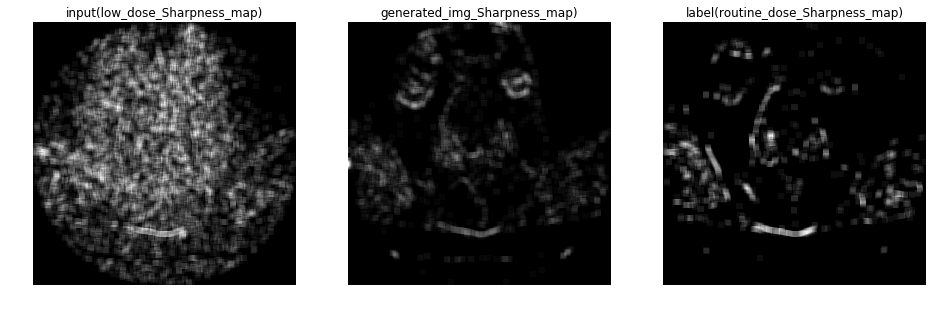

In [45]:
plot(low_dose, routine_dose, generated_img)

In [ ]:
# generator_loss + pixel_loss(generated_img_Sharpness_map, routine_dose_Sharpness_map)
# 의 형식으로 loss 값을 추가하면 될 것같습니다. 